# Vale do Pati

Scene of a valley in [Chapada Diamantina](https://en.wikipedia.org/wiki/Chapada_Diamantina), northeastern Brazil. Landsat scene is 217/069 from 2014/09/22.

In [1]:
import os
import tempfile
import matplotlib.pyplot as plt
import xlandsat as xls
import skimage.io 

## Load the data

Use xlansat to load the L2 scene and the panchromatic band. The data were cropped to a smaller region and exported to the files we're reading below.

This is the code used to crop the original scenes:
```python
region = (222000, 261000, -1425000, -1400000)
# tar file downloaded from EarthExplorer
scene = xls.load_scene("LC08_L2SP_217069_20140922_20200910_02_T1.tar", bands="red green blue".split(), region=region)
# L1 band 8 and MTL.txt file downloaded individually and placed in this folder
pan = xls.load_panchromatic("LC08_L1TP_217069_20140922_20200910_02_T1/", region=region)
plt.figure(figsize=(16, 9))
xls.composite(scene, rescale_to=(0.04, 0.25)).plot.imshow()
plt.axis("scaled")
plt.show()
xls.save_scene(f"../data/vale-do-pati/{scene.attrs['landsat_product_id']}.tar.gz", scene)
xls.save_scene(f"../data/vale-do-pati/{pan.attrs['landsat_product_id']}.tar.gz", pan.to_dataset(promote_attrs=True))
```

In [2]:
scene = xls.load_scene("../data/vale-do-pati/LC08_L2SP_217069_20140922_20200910_02_T1.tar.gz")
pan = xls.load_panchromatic("../data/vale-do-pati/LC08_L1TP_217069_20140922_20200910_02_T1.tar.gz")
scene

<xarray.Dataset>
Dimensions:   (easting: 1301, northing: 834)
Coordinates:
  * easting   (easting) float64 2.22e+05 2.22e+05 ... 2.61e+05 2.61e+05
  * northing  (northing) float64 -1.425e+06 -1.425e+06 ... -1.4e+06 -1.4e+06
Data variables:
    blue      (northing, easting) float16 0.08606 0.08557 ... 0.07007 0.06763
    green     (northing, easting) float16 0.1072 0.1099 ... 0.09216 0.09241
    red       (northing, easting) float16 0.1296 0.1455 0.1301 ... 0.1019 0.1016
Attributes: (12/19)
    Conventions:                CF-1.8
    title:                      Landsat 8 scene from 2014-09-22 (path/row=217...
    digital_object_identifier:  https://doi.org/10.5066/P9OGBGM6
    origin:                     Image courtesy of the U.S. Geological Survey
    landsat_product_id:         LC08_L2SP_217069_20140922_20200910_02_T1
    processing_level:           L2SP
    ...                         ...
    ellipsoid:                  WGS84
    date_acquired:              2014-09-22
    scene_center_time:          12:49:18.0966140Z
    wrs_path:                   217
    wrs_row:                    69
    mtl_file:                   GROUP = LANDSAT_METADATA_FILE\n  GROUP = PROD...

## Process

Fill any missing data gaps by interpolation and pan-sharpen the scene.

In [3]:
scene = xls.interpolate_missing(scene)
scene = xls.pansharpen(scene, pan)
scene

<xarray.Dataset>
Dimensions:   (northing: 1667, easting: 2601)
Coordinates:
  * northing  (northing) float64 -1.425e+06 -1.425e+06 ... -1.4e+06 -1.4e+06
  * easting   (easting) float64 2.22e+05 2.22e+05 2.22e+05 ... 2.61e+05 2.61e+05
Data variables:
    red       (northing, easting) float32 0.1058 0.1174 0.1182 ... 0.078 0.07595
    green     (northing, easting) float32 0.08747 0.09706 ... 0.07053 0.0691
    blue      (northing, easting) float32 0.07023 0.07794 ... 0.05362 0.05057
Attributes: (12/21)
    Conventions:                  CF-1.8
    title:                        Pansharpend Landsat 8 scene from 2014-09-22...
    digital_object_identifier:    https://doi.org/10.5066/P9OGBGM6
    origin:                       Image courtesy of the U.S. Geological Survey
    landsat_product_id:           LC08_L2SP_217069_20140922_20200910_02_T1
    processing_level:             L2SP
    ...                           ...
    scene_center_time:            12:49:18.0966140Z
    wrs_path:                     217
    wrs_row:                      69
    pansharpening_method:         Weighted Brovey Transform
    pansharpening_rgb_weights:    (1, 1, 0.2)
    pansharpening_band_filename:  LC08_L1TP_217069_20140922_20200910_02_T1_B8...

## Make the figure

Create a composite and make it look nice. Save to a temporary image file first since it's hard to get matplotlib to remove all empty borders and create an image that's exactly 3840 x 2160 pixels in size (4k).

In [4]:
tmp = tempfile.NamedTemporaryFile(suffix=".jpg", delete=False)
# Make sure we can read and write to this file. Windows won't allow it with open files.
tmp.close()

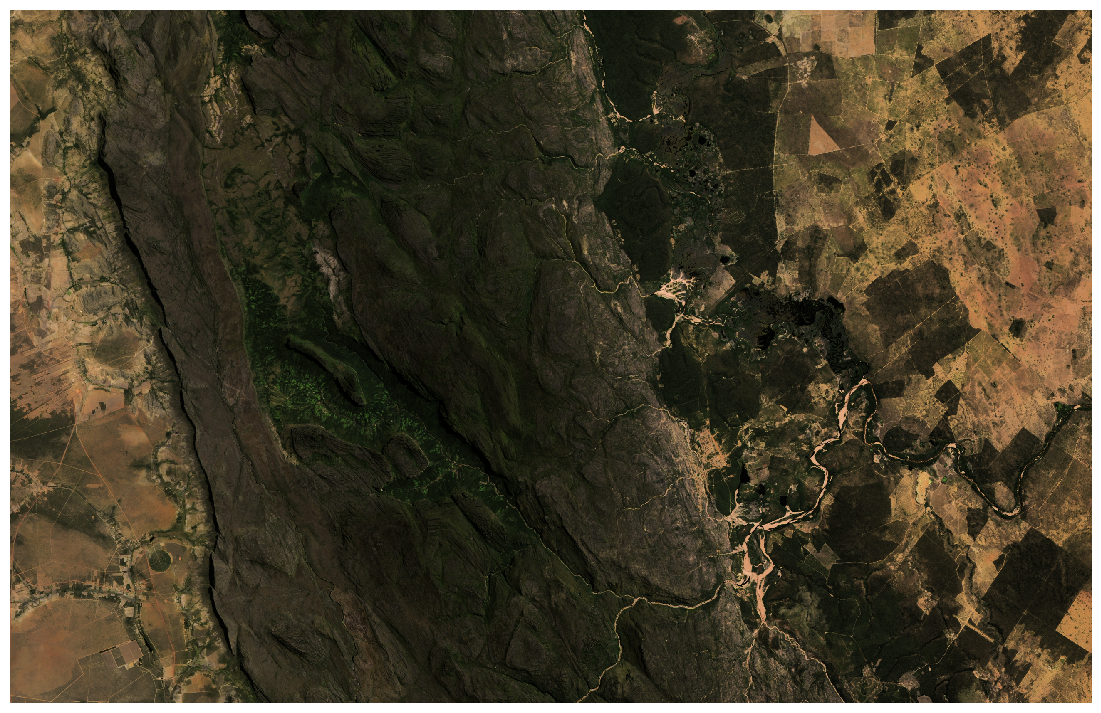

In [5]:
rgb = xls.composite(scene, rescale_to=(0.03, 0.6))
rgb = xls.equalize_histogram(rgb, kernel_size=1500, clip_limit=0.018)

plt.figure(figsize=(16, 9))
rgb.plot.imshow()
plt.axis("scaled")
plt.axis("off")

plt.savefig(tmp.name, dpi=370, bbox_inches="tight")

plt.show()

## Make the wallpaper

Read back the image and make sure it's exactly 4k.

In [6]:
image_larger = skimage.io.imread(tmp.name)
image_larger.shape

(2638, 4074, 3)

Crop to the exact pixel count.

In [7]:
x_offset = int((image_larger.shape[1] - 3840) // 2)
y_offset = int((image_larger.shape[0] - 2160) // 2)
image = image_larger[y_offset:2160 + y_offset, x_offset:3840 + x_offset, :]
assert image.shape == (2160, 3840, 3)

Plot it to make sure it's what we expect.

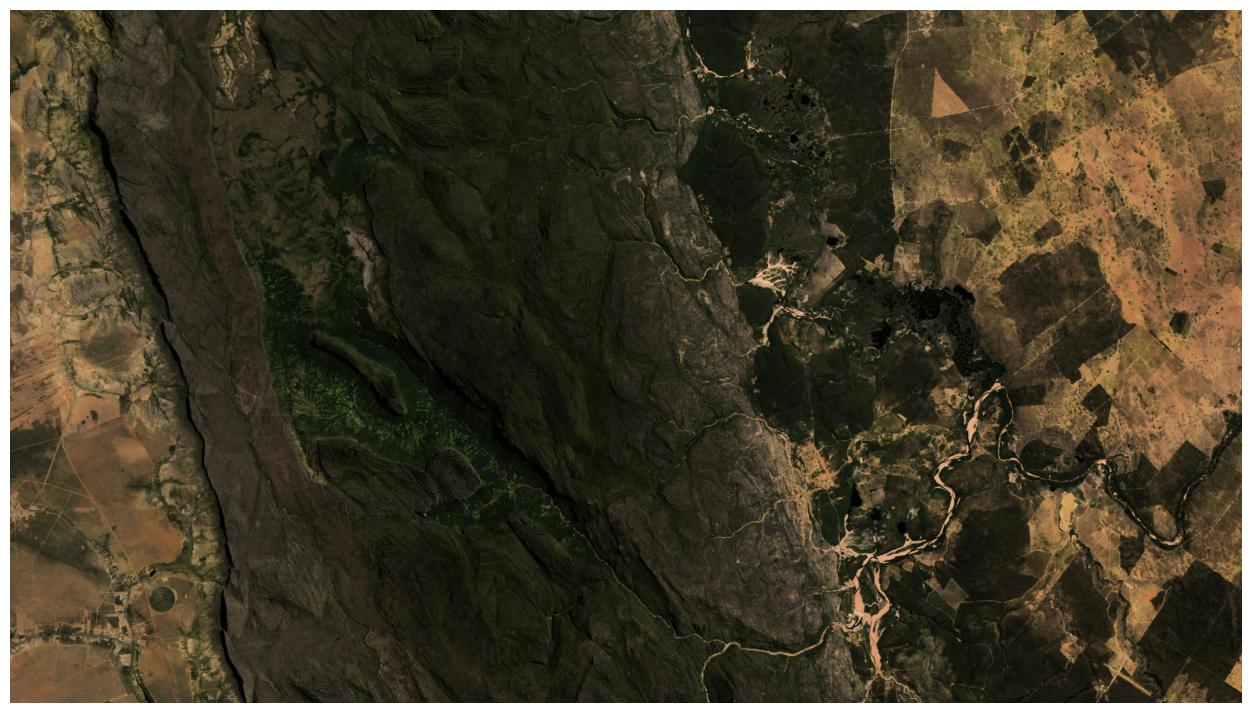

In [8]:
plt.figure(figsize=(16, 9))
plt.imshow(image)
plt.axis("scaled")
plt.axis("off")
plt.show()

Save it to the `wallpapers` folder.

In [9]:
skimage.io.imsave("../wallpapers/vale-do-pati.jpg", image, quality=100)

Clean up the temporary file.

In [10]:
os.remove(tmp.name)